In [2]:
import tensorflow as tf
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tq
from biosppy.signals import ecg
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from collections import Counter
from biosppy.signals import tools
import seaborn as sns
from scipy.signal import resample
import gc

In [3]:
sample=pd.read_csv("sample.csv")

In [4]:
train_signals = []
for x in tq(open('X_train.csv')):
    if x.startswith('id'): #header
        continue
    train_signals.append(list(map(int,x.strip().split(',')[1:])))

In [5]:
test_signals = []
for x in tq(open('X_test.csv')):
    if x.startswith('id'): #header
        continue
    test_signals.append(list(map(int,x.strip().split(',')[1:])))

In [6]:
train_labels = np.array(pd.read_csv('y_train.csv')['y'])

In [21]:
def unfold_data(index):
    X_data = []
    X_label = []
    for i in index:
        h = []
        for t in ecg_outs[i]['templates']:
            h.append(t)
        X_data.append(np.mean(h,axis=0))
        X_label.append(train_labels[i])
    return np.array(X_data).reshape(len(X_data),180,1), np.array(X_label)
    # return np.array(X_data), np.array(X_label)


MAX_DIM = 17813


def process_signal(sig):
  filtered, _, _ = tools.filter_signal(signal=sig,
                                  ftype='FIR',
                                  band='bandpass',
                                  order=90,
                                  frequency=[3, 45],
                                  sampling_rate=300)
  return tools.normalize(filtered)[0]

def unfold_data2(index):
    X_data = []
    X_label = []
    for i in tq(index):
        signal = process_signal(train_signals[i])
        # signal = np.array(train_signals[i])
        # signal = np.hstack(ecg_outs[i]['templates'])
        rem = MAX_DIM - signal.shape[0]
        if rem:
            signal = np.hstack((signal,np.zeros((rem,))))
        X_data.append(signal.reshape((MAX_DIM,1)))
        X_label.append(train_labels[i])
    return np.array(X_data), np.array(X_label)


def expand_data(index,is_train=False):

    EXPANSION_SIZE = 5
    if is_train:
        X_data = np.zeros((len(index)*(EXPANSION_SIZE+1),MAX_DIM,1))
    else:
        X_data = np.zeros((len(index),MAX_DIM,1))
    X_label = []
    idx = 0
    for i in tq(index):
        def add_sig(sig,label, idx):
            signal = process_signal(sig)
            # signal = np.array(train_signals[i])
            # signal = np.hstack(ecg_outs[i]['templates'])
            rem = MAX_DIM - signal.shape[0]
            if rem:
                signal = np.hstack((signal,np.zeros((rem,))))
            X_data[idx] = signal.reshape((MAX_DIM,1))
            X_label.append(label)
        add_sig(train_signals[i], train_labels[i], idx)
        idx += 1
        if is_train:
            for rrr in range(EXPANSION_SIZE):
                l = len(train_signals[i])
                seg_l = np.random.randint(2400,l)
                start = np.random.randint(0,l-seg_l)
                add_sig(train_signals[i][start:start+seg_l], train_labels[i], idx)
                idx+=1

    return X_data, np.array(X_label)


def expand_data2(index,is_train=False):
    MAX_DIM = int(17813*1.2)
    EXPANSION_SIZE = 3
    if is_train:
        X_data = np.zeros((len(index)*(EXPANSION_SIZE+1),MAX_DIM,1))
    else:
        X_data = np.zeros((len(index),MAX_DIM,1))
    X_label = []
    idx = 0
    for i in tq(index):
        def add_sig(sig,label, idx):
            signal = process_signal(sig)
            # signal = np.array(train_signals[i])
            # signal = np.hstack(ecg_outs[i]['templates'])
            rem = MAX_DIM - signal.shape[0]
            if rem:
                signal = np.hstack((signal,np.zeros((rem,))))
            X_data[idx] = signal.reshape((MAX_DIM,1))
            X_label.append(label)
        add_sig(train_signals[i], train_labels[i], idx)
        idx += 1
        if is_train:
            stretch_ratio = 1. + np.random.random()/5 # [1,1.2]
            stretch_len = int(len(train_signals[i])*stretch_ratio)
            add_sig(resample(train_signals[i],stretch_len), train_labels[i], idx)
            idx += 1
            l = len(train_signals[i])//2
            add_sig(train_signals[i][:l], train_labels[i],idx)
            idx+=1
            add_sig(train_signals[i][l:], train_labels[i],idx)
            idx+=1
    return X_data, np.array(X_label)

def expand_data3(index,is_train=False):
    MAX_DIM = int(17813*1.2)
    EXPANSION_SIZE = 4
    if is_train:
        X_data = np.zeros((len(index)*(EXPANSION_SIZE+1),MAX_DIM,1))
    else:
        X_data = np.zeros((len(index),MAX_DIM,1))
    X_label = []
    idx = 0
    for i in tq(index):
        def add_sig(sig,label, idx):
            signal = process_signal(sig)
            # signal = np.array(train_signals[i])
            # signal = np.hstack(ecg_outs[i]['templates'])
            rem = MAX_DIM - signal.shape[0]
            if rem:
                signal = np.hstack((signal,np.zeros((rem,))))
            X_data[idx] = signal.reshape((MAX_DIM,1))
            X_label.append(label)
        add_sig(train_signals[i], train_labels[i], idx)
        idx += 1
        if is_train:
            #streteched
            stretch_ratio = 1. + np.random.random()/5 # [1,1.2]
            stretch_len = int(len(train_signals[i])*stretch_ratio)
            add_sig(resample(train_signals[i],stretch_len), train_labels[i], idx)
            idx += 1
            
            #masked
            sig = np.array(train_signals[i])
            mask_l = np.random.randint(10,450)
            l = len(train_signals[i])
            start = np.random.randint(0,l-mask_l)
            sig[start:start+mask_l] = 0
            add_sig(sig, train_labels[i], idx)
            idx += 1
            
            #sliced
            l = len(train_signals[i])//2
            add_sig(train_signals[i][:l], train_labels[i],idx)
            idx+=1
            add_sig(train_signals[i][l:], train_labels[i],idx)
            idx+=1
    return X_data, np.array(X_label)

def unfold_data3(index):
    X_data = []
    X_label = []
    for i in tq(index):
        signal = process_signal(train_signals[i])
        # signal = np.array(train_signals[i])
        # signal = np.hstack(ecg_outs[i]['templates'])
        rem = MAX_DIM - signal.shape[0]
        while rem > 0:
            signal = np.hstack((signal,signal[:rem]))
            rem = MAX_DIM - signal.shape[0]
        X_data.append(signal.reshape((MAX_DIM,1)))
        X_label.append(train_labels[i])
    return np.array(X_data), np.array(X_label)

MAX_BEATS = 28260
def unfold_data_beats(index):
    X_data = []
    X_label = []
    for i in tq(index):
        # signal = process_signal(train_signals[i])
        # signal = np.array(train_signals[i])
        # signal = np.hstack(ecg_outs[i]['templates'])
        signal = tools.normalize(np.hstack(ecg_outs[i]['templates']))[0]
        rem = MAX_BEATS - signal.shape[0]
        if rem:
            signal = np.hstack((signal,np.zeros((rem,))))
        X_data.append(signal.reshape((MAX_BEATS,1)))
        X_label.append(train_labels[i])
    return np.array(X_data), np.array(X_label)

def class_weights(y):
    c = Counter(y)
    w = []
    for i in range(4):
        w.append(1/c[i])
    w = np.array(w)
    # w[2] = w[2]*2  # Don't forget to remove
    w = w/np.sum(w)
    
    return w

In [28]:
MAX_DIM = int(17813*1.2)
X_submit = []
for sig in tq(test_signals):
    signal = process_signal(sig)
    # signal = np.array(sig)
    rem = MAX_DIM - signal.shape[0]
    if rem:
        signal = np.hstack((signal,np.zeros((rem,))))
    X_submit.append(signal.reshape((MAX_DIM,1)))
X_submit = np.array(X_submit)

/usr/local/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/usr/local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.ar

In [43]:
def get_model():
    model = tf.keras.Sequential([
      tf.keras.layers.Conv1D(32,10,2,activation="relu"),
      tf.keras.layers.Conv1D(32,10,1,activation="relu"),
      tf.keras.layers.MaxPooling1D(3),
      tf.keras.layers.Dropout(rate=0.3),
      tf.keras.layers.Conv1D(64,10,2,activation="relu"),
      tf.keras.layers.Conv1D(64,10,1,activation="relu"),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Dropout(rate=0.3),
      tf.keras.layers.Conv1D(128,10,2,activation="relu"),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Dropout(rate=0.3),
      tf.keras.layers.Conv1D(256,10,2,activation="relu"),
      tf.keras.layers.GlobalMaxPooling1D(),
      tf.keras.layers.Dense(256,activation="relu"),
      tf.keras.layers.Dense(30,activation="relu"),
      tf.keras.layers.Dense(4,activation="softmax") 
    ])
    return model

In [52]:
def add_common_layers(y, first_layer=False, first=32, sec=128):
    shortcut = y
    if first_layer:
        shortcut = tf.keras.layers.Conv1D(sec, 3, 1, padding="same")(shortcut)
    else:
        shortcut = tf.keras.layers.Conv1D(sec, 3, 2, padding="same")(shortcut)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    if first_layer:
        y = tf.keras.layers.Conv1D(first, 1, 1, padding="same")(y)
    else:
        y = tf.keras.layers.Conv1D(first, 1, 2, padding="same")(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation("relu")(y)

    y = tf.keras.layers.Conv1D(first, 3, 1, padding="same")(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation("relu")(y)

    y = tf.keras.layers.Conv1D(sec, 1, 1, padding="same")(y)
    y = tf.keras.layers.BatchNormalization()(y)

    y = tf.keras.layers.add([shortcut, y])
    y = tf.keras.layers.Activation("relu")(y)

    return y

def residual_network(x):
    x = tf.keras.layers.Conv1D(32, 5, 2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = add_common_layers(x, first_layer=True)
    x = add_common_layers(x, first_layer=False, first=64, sec=256)
    x = add_common_layers(x, first_layer=False, first=128, sec=512)
    x = add_common_layers(x, first_layer=False, first=256, sec=1024)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(40, activation="tanh")(x)
    x = tf.keras.layers.Dense(4,activation="softmax")(x)
    return x


def get_model(size_train):
    sig_tensor = tf.keras.layers.Input(shape=size_train)
    network_output = residual_network(sig_tensor)
    model = tf.keras.models.Model(inputs=[sig_tensor], outputs=[network_output])

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam')
    return model

In [53]:
import numpy as np
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(Callback):

  def __init__(self,X_train,y_train,X_test,y_test, *args,**kwargs):
    super().__init__(*args,**kwargs)
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test

  def on_train_begin(self, logs={}):
    self.val_f1s = []
    self.val_recalls = []
    self.val_precisions = []
    self.train_f1s = []
    self.train_recalls = []
    self.train_precisions = []
  
  def on_epoch_end(self, epoch, logs={}):
    val_predict = np.argmax(self.model.predict(self.X_test),axis=1)
#     val_predict = np.asarray(self.model.predict_classes(self.X_test))
    val_targ = self.y_test
    _val_f1 = f1_score(val_targ, val_predict,average='micro')
    _val_recall = recall_score(val_targ, val_predict,average='micro')
    _val_precision = precision_score(val_targ, val_predict,average='micro')
    self.val_f1s.append(_val_f1)
    self.val_recalls.append(_val_recall)
    self.val_precisions.append(_val_precision)
    print("— val_f1: %f" % _val_f1)

#     train_predict = np.asarray(self.model.predict_classes(self.X_train))
#     train_targ = self.y_train
#     _train_f1 = f1_score(train_targ, train_predict,average='micro')
#     _train_recall = recall_score(train_targ, train_predict,average='micro')
#     _train_precision = precision_score(train_targ, train_predict,average='micro')
#     self.train_f1s.append(_train_f1)
#     self.train_recalls.append(_train_recall)
#     self.train_precisions.append(_train_precision)
    return


In [54]:
from sklearn.model_selection import train_test_split

train_index, test_index = train_test_split(list(range(len(train_labels))), test_size=0.1,shuffle=True, random_state=42,stratify=train_labels)

In [55]:
gc.collect()

2145

In [ ]:
from tensorflow.keras.optimizers import Adam
# X_train, y_train = expand_data3(train_index, is_train=True)
# X_test, y_test = expand_data3(test_index)
metrics = Metrics(X_train, y_train, X_test,y_test)
model = get_model(X_train.shape[1:])
model.compile(optimizer=Adam(learning_rate=0.001),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=["sparse_categorical_accuracy"])
history = model.fit(X_train,y_train, batch_size=10,epochs=30,callbacks=[metrics],shuffle=True,class_weight=class_weights(y_train))

Train on 23025 samples
Epoch 1/30
23025/23025 [==============================] - 120s 5ms/sample - loss: 0.9019 - sparse_categorical_accuracy: 0.6045
Epoch 2/30
10690/23025 [============>.................] - ETA: 59s - loss: 0.7976 - sparse_categorical_accuracy: 0.6319

In [27]:
for i in range(0,30,5):
    print('%d-%d epochs f1 mean' % (i,i+5), np.mean(metrics.val_f1s[i:i+5]))
    print('%d-%d epochs f1 std'%(i,i+5), np.std(metrics.val_f1s[i:i+5]))

# print('Last 5 epochs f1 mean', np.mean(metrics.val_f1s[-5:]))
# print('Last 5 epochs f1 std', np.std(metrics.val_f1s[-5:]))

0-5 epochs f1 mean 0.80234375
0-5 epochs f1 std 0.019933360659645426
5-10 epochs f1 mean 0.830078125
5-10 epochs f1 std 0.011587810136086974
10-15 epochs f1 mean 0.838671875
10-15 epochs f1 std 0.00705291800205773
15-20 epochs f1 mean 0.841015625
15-20 epochs f1 std 0.009695057535930357
20-25 epochs f1 mean 0.83359375
20-25 epochs f1 std 0.006810779599282302
25-30 epochs f1 mean 0.825390625
25-30 epochs f1 std 0.009210801658243435


In [ ]:
pred = model.predict_classes(X_test)

In [34]:
np.array(test_index)[(pred==0) & (y_test==2)]

array([  66, 1492, 3379, 1795, 5101, 2453, 1375, 4743, 3295, 2486, 3512,
       4408, 1432, 2242, 1038, 4403, 1247,  759, 3525,  478, 3301, 2561,
       3583, 3194, 2755, 1036,  272, 3321, 4219, 1879, 1522, 3903, 3588,
        392,  566, 2204, 1664, 3626,   95, 4515, 2343])

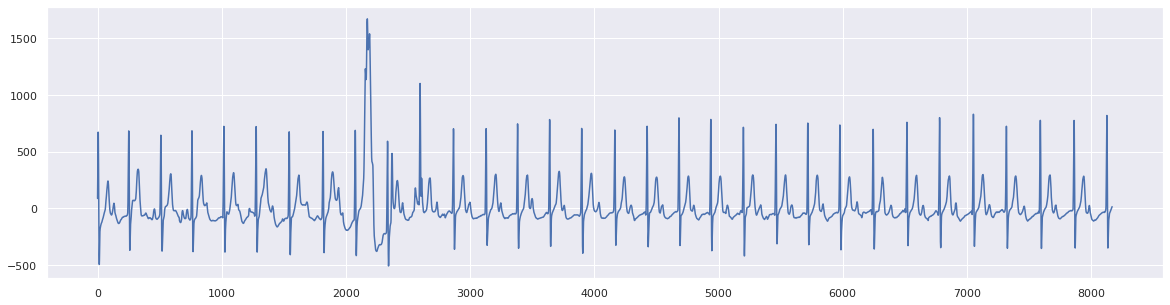

In [41]:
sns.set(rc={'figure.figsize':(20,5)})
plt.figure()
num = 2561
sns.lineplot(x=range(0, len(train_signals[num])), y=train_signals[num])
plt.show()

(array([ 2.,  1.,  4.,  2.,  9.,  7., 13., 10., 17., 14., 16., 24., 15.,
        12., 22., 16., 14., 22., 20., 15., 15.,  9., 12., 10.,  5.,  7.,
         6., 14.,  7.,  3.,  3.,  4.,  5.,  4.,  6.,  4.,  2.,  4.,  1.,
         2.,  2.,  1.,  1.,  4.,  2.,  1.,  0.,  1.,  5.,  0.,  1.,  0.,
         1.,  3.,  2.,  0.,  2.,  2.,  3.,  0.,  1.,  0.,  0.,  0.,  3.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 40.61035217,  47.72144176,  54.83253134,  61.94362093,
         69.05471052,  76.1658001 ,  83.27688969,  90.38797927,
         97.49906886, 104.61015844, 111.72124803, 118.83233761,
        125.9434272 , 133.05451678, 140.16560637, 147.27669595,
        154.38778554, 161.49887512, 168.60996471, 175.72105429,
        182.83214388, 189.94323346, 197.05432305, 204.16541264,
        211.27650222, 218.38759181, 225.49868139, 

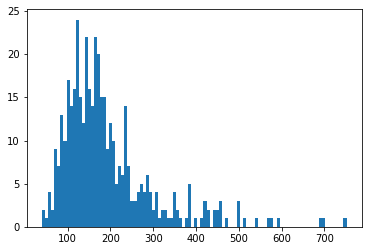

In [ ]:
lens = np.array([np.std(sig) for sig in train_signals])
plt.hist(lens[test_index][pred==y_test],bins=100)

(array([1., 0., 0., 1., 1., 3., 3., 3., 3., 2., 1., 2., 2., 2., 3., 5., 4.,
        1., 0., 3., 7., 4., 4., 4., 3., 2., 1., 3., 1., 2., 2., 0., 0., 2.,
        2., 2., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 70.21277665,  75.32300447,  80.43323229,  85.54346011,
         90.65368793,  95.76391575, 100.87414357, 105.9843714 ,
        111.09459922, 116.20482704, 121.31505486, 126.42528268,
        131.5355105 , 136.64573832, 141.75596614, 146.86619396,
        151.97642178, 157.08664961, 162.19687743, 167.30710525,
        172.41733307, 177.52756089, 182.63778871, 187.74801653,
        192.85824435, 197.96847217, 203.0787    , 208.18892782,
        213.29915564, 218.40938346, 223.51961128, 228.6298391 ,
        233.74006692, 238.85029474, 24

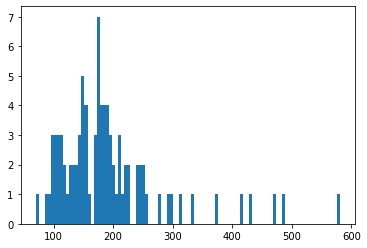

In [ ]:
lens = np.array([np.std(sig) for sig in train_signals])
plt.hist(lens[test_index][pred!=y_test],bins=100)

[[289   1  12   1]
 [  5  29  10   0]
 [ 44   9  90   5]
 [  4   0   0  13]]


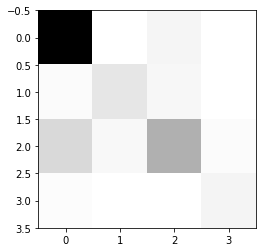

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm=confusion_matrix(y_test,pred)
print(cm)
plt.imshow(cm,cmap='binary')

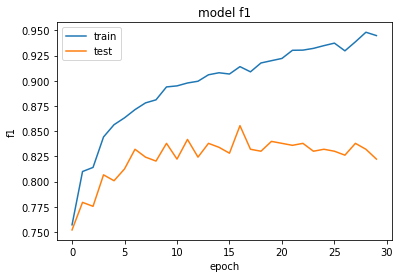

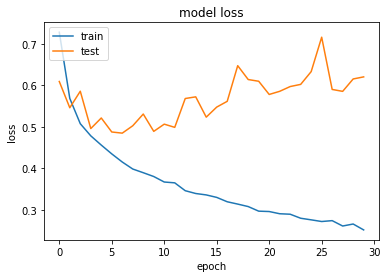

In [30]:



plt.plot(metrics.train_f1s)
plt.plot(metrics.val_f1s)
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

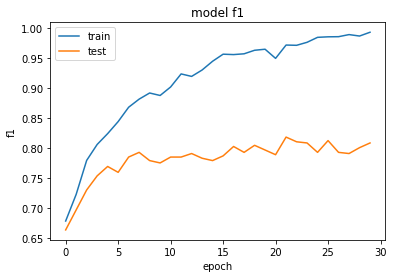

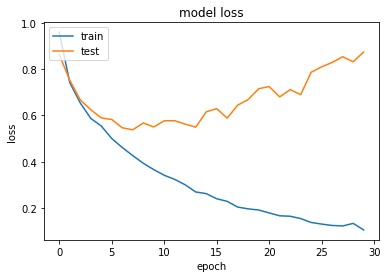

In [ ]:
import matplotlib.pyplot as plt


plt.plot(metrics.train_f1s)
plt.plot(metrics.val_f1s)
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.fit(X_train,y_train, validation_data = (X_test, y_test), batch_size=10,epochs=30,callbacks=[metrics],shuffle=True)

Train on 4605 samples, validate on 512 samples
Epoch 1/30
4605/4605 [==============================] - 6s 1ms/sample - loss: 0.1912 - sparse_categorical_accuracy: 0.9286 - val_loss: 0.7732 - val_sparse_categorical_accuracy: 0.7930
Epoch 2/30
4605/4605 [==============================] - 6s 1ms/sample - loss: 0.1956 - sparse_categorical_accuracy: 0.9290 - val_loss: 0.7293 - val_sparse_categorical_accuracy: 0.8066
Epoch 3/30
4605/4605 [==============================] - 6s 1ms/sample - loss: 0.1718 - sparse_categorical_accuracy: 0.9398 - val_loss: 0.6658 - val_sparse_categorical_accuracy: 0.8184
Epoch 4/30
4605/4605 [==============================] - 6s 1ms/sample - loss: 0.1605 - sparse_categorical_accuracy: 0.9401 - val_loss: 0.8023 - val_sparse_categorical_accuracy: 0.8027
Epoch 5/30
4605/4605 [==============================] - 6s 1ms/sample - loss: 0.1694 - sparse_categorical_accuracy: 0.9401 - val_loss: 0.6610 - val_sparse_categorical_accuracy: 0.8008
Epoch 6/30
4605/4605 [===========

In [31]:
import numpy as np
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class TestSubmit(Callback):

    def __init__(self,X_test, *args,**kwargs):
        super().__init__(*args,**kwargs)
        self.X_test = X_test


    def on_train_begin(self, logs={}):
        self.preds = {}
  
    def on_epoch_end(self, epoch, logs={}):
        self.preds[epoch] = self.model.predict_classes(self.X_test)
        return


In [32]:
model = get_model()
X_train, y_train = expand_data3(list(range(len(train_signals))),is_train=True)
model.compile(optimizer=Adam(learning_rate=0.001),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=["sparse_categorical_accuracy"],weights=class_weights(y_train))
test_submit = TestSubmit(X_submit)
model.fit(X_train,y_train, batch_size=10,epochs=20,shuffle=True,callbacks=[test_submit])

Train on 25585 samples
Epoch 1/20
25585/25585 [==============================] - 21s 821us/sample - loss: 0.6915 - sparse_categorical_accuracy: 0.7211
Epoch 2/20
25585/25585 [==============================] - 20s 773us/sample - loss: 0.5298 - sparse_categorical_accuracy: 0.7930
Epoch 3/20
25585/25585 [==============================] - 20s 775us/sample - loss: 0.4723 - sparse_categorical_accuracy: 0.8193
Epoch 4/20
25585/25585 [==============================] - 20s 778us/sample - loss: 0.4343 - sparse_categorical_accuracy: 0.8341
Epoch 5/20
25585/25585 [==============================] - 20s 775us/sample - loss: 0.4187 - sparse_categorical_accuracy: 0.8438
Epoch 6/20
25585/25585 [==============================] - 20s 774us/sample - loss: 0.3975 - sparse_categorical_accuracy: 0.8511
Epoch 7/20
25585/25585 [==============================] - 20s 778us/sample - loss: 0.3780 - sparse_categorical_accuracy: 0.8608
Epoch 8/20
25585/25585 [==============================] - 20s 772us/sample - loss

In [33]:
y_pred = []
for i in tq(range(len(X_submit))):
    votes = []
    for ep in [15,16,17,18,19]:
        votes.append(test_submit.preds[ep][i])
    y_pred.append(Counter(votes).most_common(1)[0][0])
        

In [34]:
y_pred = model.predict_classes(X_submit)

In [35]:
sample['y']=y_pred

In [36]:
sample.to_csv("stretched_soorakh_majority_16to20.csv",index=False)